In [ ]:
import geopandas as gpd
import os
import pandas as pd
import openrouteservice
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
os.chdir("/home/silas/projects/msc_thesis")

In [2]:
#set Api key for ORS
api_key= "5b3ce3597851110001cf624865e19fb4d0c2400e9aba8877785f6853"

#import flat dataset
flats_zh= gpd.read_file(r'./data/raw_data/geodata_stadt_Zuerich/building_stats/data/ssz.gwr_stzh_wohnungen.shp')

#import rcp dataset
rcps = gpd.read_file(r'./data/raw_data/geodata_stadt_Zuerich/recycling_sammelstellen/data/stzh.poi_sammelstelle_view.shp')


#filter out demolished flats
flats_zh_existing=flats_zh.query('wstatlang=="Bestehend"')
flats_zh_existing['egid']=flats_zh_existing['egid'].astype(int)

#filter out flats with no coordinates

#make sure every building occures only once
flats_zh_existing=flats_zh_existing.drop_duplicates(subset=['egid'])

# check if CRS are matching
print("Current CRS:", flats_zh_existing.crs)
print("Current CRS:", rcps.crs)


Current CRS: epsg:2056
Current CRS: epsg:2056


/home/silas/miniconda3/envs/rasterio_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [3]:
nr_flats_zh= len(flats_zh_existing)

In [4]:
# Create a subset of n flats
n = 10
buffer_distance = 600
flats_subset = flats_zh_existing.iloc[1:n,].copy()

# Create buffer
flats_subset['buffer'] = flats_subset.geometry.buffer(buffer_distance)

def find_points_in_buffer(buffer_geom):
    return rcps[rcps.geometry.within(buffer_geom)]

# Apply function to each buffer, save in dataframe
results = pd.DataFrame(columns=['flat_id', 'rcp'])
for idx, row in flats_subset.iterrows():
    points_in_buffer = find_points_in_buffer(row['buffer'])
    if not points_in_buffer.empty:
        # For each point in the buffer, add a new row
        for point_idx in points_in_buffer.index:
            results.loc[len(results)] = {
                'flat_id': row['egid'],
                'rcp': point_idx
            }

In [5]:
#function to get coordinates for rcp x
def get_rcp_coordinates(rcp_id):
   return rcps.geometry[rcp_id]

#function to get coordinates for each flat_id
def get_flat_coordinates(flat_id):
   return flats_subset.loc[flats_subset['egid']==flat_id, 'geometry']

In [6]:
# Create ors client using the API key
client = openrouteservice.Client(key=api_key)

#convert to WGS84 for ORS API
flats_subset = flats_subset.to_crs(epsg=4326)
rcps = rcps.to_crs(epsg=4326)

# Function to calculate the walking route between a flat and a recycling point
def calculate_walking_route(flat_id, rcp_id):
    flat_coords = get_flat_coordinates(flat_id).values[0]
    rcp_coords = get_rcp_coordinates(rcp_id)
    # Get the coordinates in the format required by OpenRouteService
    coords = ([flat_coords.x, flat_coords.y], [rcp_coords.x, rcp_coords.y])
    
    # Request the route from OpenRouteService
    route = client.directions(
        coordinates=coords,
        profile='foot-walking',
        format='geojson'
    )
    
    # Extract distance and duration
    distance = route['features'][0]['properties']['segments'][0]['distance']
    duration = route['features'][0]['properties']['segments'][0]['duration']
    
    return distance, duration

# Apply the function to each row in the results dataframe
results['distance'] = 0.0
results['duration'] = 0.0

for idx, row in results.iterrows():
    distance, duration = calculate_walking_route(row['flat_id'], row['rcp'])
    results.at[idx, 'distance'] = distance
    results.at[idx, 'duration'] = duration/60 # Convert seconds to minutes


In [7]:
# function to find closest rcp to each flat and merge the information back to the flats dataframe
def map_closest_rcp_to_flats(flats_df, results_df):
    # Find the closest rcp for each flat
    closest_rcp = results_df.loc[results_df.groupby('flat_id')['duration'].idxmin()]
    
    # Merge the closest rcp information back to the flats dataframe
    flats_df = flats_df.merge(closest_rcp[['flat_id', 'rcp', 'distance', 'duration']], 
                              left_on='egid', right_on='flat_id', how='left')
    
    return flats_df

# Apply the function
flats_subset_with_rcp = map_closest_rcp_to_flats(flats_subset, results)

In [8]:
flats_subset_with_rcp.drop(columns=['buffer', 'flat_id'], inplace=True)

egid  ewid  edid whgnr  wstwk                     wstwklang  wbez  \
0  145253     3     0   201   3102                      2. Stock  None   
1  144667     1     0     1   3100  Parterre, inkl. Hochparterre  None   
2  144668     1     0     1   3100  Parterre, inkl. Hochparterre  None   
3  144669     1     0     1   3100  Parterre, inkl. Hochparterre  None   
4  144670     1     0     1   3100  Parterre, inkl. Hochparterre  None   
5  144671     1     0     1   3100  Parterre, inkl. Hochparterre  None   
6  144672     3     0     1   3100  Parterre, inkl. Hochparterre  None   
7  144684     1     0     1   3100  Parterre, inkl. Hochparterre  None   
8  144687     1     0     1   3100  Parterre, inkl. Hochparterre  None   

   wmehrg wmehrglang   wbauj  ...  dplz4  dplzname         dexpdat  objectid  \
0       0       Nein  1999.0  ...   8055    Zürich  20241007000000   25842.0   
1       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21170.0   
2       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21171.0   
3       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21172.0   
4       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21173.0   
5       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21174.0   
6       0       Nein  1999.0  ...   8055    Zürich  20241007000000   21175.0   
7       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21207.0   
8       1         Ja  1999.0  ...   8055    Zürich  20241007000000   21210.0   

                   geometry  \
0  POINT (8.51583 47.36683)   
1  POINT (8.51466 47.36713)   
2  POINT (8.51458 47.36708)   
3  POINT (8.51428 47.36681)   
4  POINT (8.51488 47.36725)   
5  POINT (8.51473 47.36741)   
6  POINT (8.51459 47.36754)   
7  POINT (8.51433 47.36687)   
8  POINT (8.51439 47.36731)   

                                              buffer flat_id  rcp  distance  \
0  POLYGON ((2681965.535 1246779.539, 2681962.646...  145253  131     276.8   
1  POLYGON ((2681876.647 1246810.577, 2681873.758...  144667  130     211.2   
2  POLYGON ((2681871.061 1246805.713, 2681868.172...  144668  130     203.9   
3  POLYGON ((2681848.337 1246775.161, 2681845.448...  144669  130     167.9   
4  POLYGON ((2681893.063 1246825.017, 2681890.174...  144670  130     232.9   
5  POLYGON ((2681881.701 1246842.535, 2681878.812...  144671  130     274.0   
6  POLYGON ((2681871.175 1246856.481, 2681868.286...  144672  130     291.4   
7  POLYGON ((2681852.175 1246781.735, 2681849.286...  144684  130     175.4   
8  POLYGON ((2681855.937 1246830.907, 2681853.048...  144687  130     230.7   

   duration  
0  3.321667  
1  2.535000  
2  2.446667  
3  2.015000  
4  2.795000  
5  3.288333  
6  3.496667  
7  2.105000  
8  2.768333  

[9 rows x 31 columns]

In [9]:
# visualize the results 
# Create a base map
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Create a colormap for the duration
colormap = folium.LinearColormap(colors=['green', 'yellow', 'red'], vmin=results['duration'].min(), vmax=results['duration'].max(), caption='Duration to Closest RCP (minutes)')

# Add flats to the map
for idx, row in flats_subset_with_rcp.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color=colormap(row['duration']),
        fill=True,
        fill_color=colormap(row['duration']),
        fill_opacity=0.7,
        popup=f"Flat ID: {row['egid']}<br>Duration: {row['duration']:.2f} min"
    ).add_to(m)

# Add recycling points to the map
for idx, row in rcps.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='blue', icon='recycle', prefix='fa', ),
        popup=f"RCP ID: {idx}<br>Address: {row['adresse']}", radius=3
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Display the map
m

In [13]:
print(rcps.crs)
print(flats_subset_with_rcp.crs)

EPSG:4326
EPSG:4326


In [35]:
# Map flats and recycling points in Zurich

# Create a base map
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

folium.TileLayer('cartodbpositron', attr='Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.').add_to(m)
folium.TileLayer('cartodbdark_matter', attr='Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.').add_to(m)
folium.LayerControl().add_to(m)

# Add flats to the map
for idx, row in flats_zh_existing.to_crs(4326).iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        fill_opacity=0.8,
        lengend_name='Flats',
        #popup=f"Flat ID: {row['egid']}"
    ).add_to(m)

# Add recycling points to the map
for idx, row in rcps.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        fill=True,
        color='green',
        popup=f"RCP ID: {idx}<br>Address: {row['adresse']}",
        legend_name='Recycling Points'
    ).add_to(m)

title_html = '''
<h3 align="center" style="font-size:25px"><b>Flats in Zurich</b></h3>
'''
# Add title to map
m.get_root().html.add_child(folium.Element(title_html))

# Save the map
m.save('./data/derived_data/map_flats+rcps.html')

In [ ]:
import folium
from folium.plugins import MarkerCluster
from branca.element import Template, MacroElement

# Create a base map
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Add tile layers
folium.TileLayer(
    'cartodbpositron', 
    attr='Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
).add_to(m)
folium.TileLayer(
    'cartodbdark_matter', 
    attr='Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
).add_to(m)
folium.LayerControl().add_to(m)

# Add flats to the map
for idx, row in flats_zh_existing.to_crs(4326).iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        fill_opacity=0.8,
        color='blue',          # Color for Flats
        fill_color='blue',
        popup=f"Flat ID: {row['egid']}"
    ).add_to(m)

# Add recycling points to the map
for idx, row in rcps.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        fill=True,
        color='green',         # Color for Recycling Points
        fill_color='green',
        popup=f"RCP ID: {idx}<br>Address: {row['adresse']}"
    ).add_to(m)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:25px"><b>Flats in Zurich</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Define the HTML template for the legend
legend_html = '''
{% macro html(this, kwargs) %}

<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 150px; height: 90px; 
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white;
    opacity: 0.8;
    ">
    <div style="padding: 10px;">
        <h4>Legend</h4>
        <i style="background: blue; width: 10px; height: 10px; float: left; margin-right: 8px; opacity: 0.7;"></i> Flats<br>
        <i style="background: green; width: 10px; height: 10px; float: left; margin-right: 8px; opacity: 0.7;"></i> Recycling Points
    </div>
</div>

{% endmacro %}
'''

# Create and add the legend to the map
legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Save the map with the legend
m.save('./data/derived_data/map_flats_rcps.html')


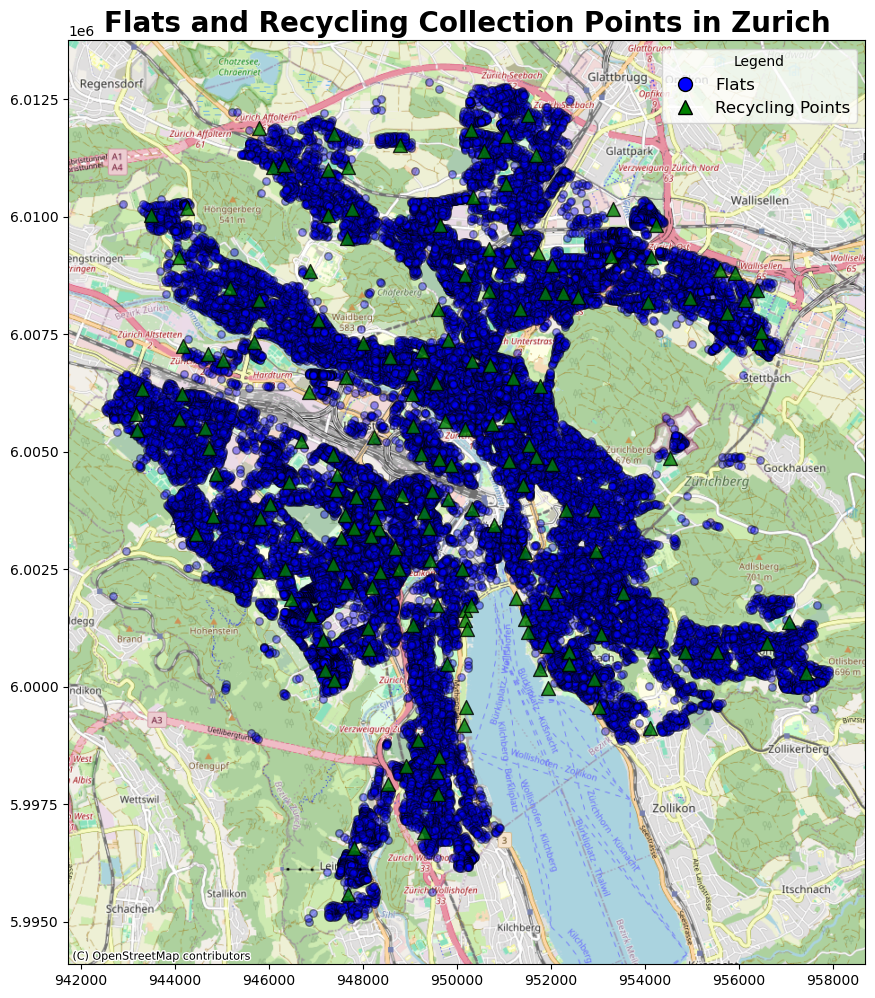

In [ ]:


# Ensure CRS is WGS84
flats_zh_existing = flats_zh_existing.to_crs(epsg=4326)
rcps = rcps.to_crs(epsg=4326)

# Project to Web Mercator for basemap
flats_web_mercator = flats_zh_existing.to_crs(epsg=3857)
rcps_web_mercator = rcps.to_crs(epsg=3857)

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Flats
flats_web_mercator.plot(
    ax=ax,
    color='blue',
    markersize=30,
    label='Flats',
    alpha=0.4,
    edgecolor='k'
)

# Plot Recycling Points
rcps_web_mercator.plot(
    ax=ax,
    color='green',
    markersize=100,
    label='Recycling Points',
    marker='^',
    alpha=0.8,
    edgecolor='k'
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Add title
plt.title('Flats and Recycling Collection Points in Zurich', fontsize=20, fontweight='bold')

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Flats',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='^', color='w', label='Recycling Points',
           markerfacecolor='green', markersize=10, markeredgecolor='k')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12, title='Legend')

# Remove axes
#ax.set_axis_off()

# Save the map
fig.savefig('./data/derived_data/map_flats_rcps.png', dpi=355, bbox_inches='tight')

# Display the map
plt.show()

# Create a heat map to visualise the resutls 



In [10]:
# create a heat map with folium

# Create a base map
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Prepare data for heatmap
heat_data = [[row.geometry.y, row.geometry.x, row['duration']] for idx, row in flats_subset_with_rcp.iterrows()]

# Add recycling points to the map
for idx, row in rcps.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        icon=folium.Icon(color='green', icon='recycle', prefix='fa'),
        fill_opacity=0.7,
        color='red',
        popup=f"RCP ID: {idx}<br>Address: {row['adresse']}"
    ).add_to(m)

# Create and add heatmap to the map
HeatMap(heat_data, radius=15, blur=12, max_zoom=1).add_to(m)

# save the map
m.save('./data/derived_data/map_flats_rcps_heatmap.html')
m


/tmp/ipykernel_35774/2717682925.py:30: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_35774/2717682925.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


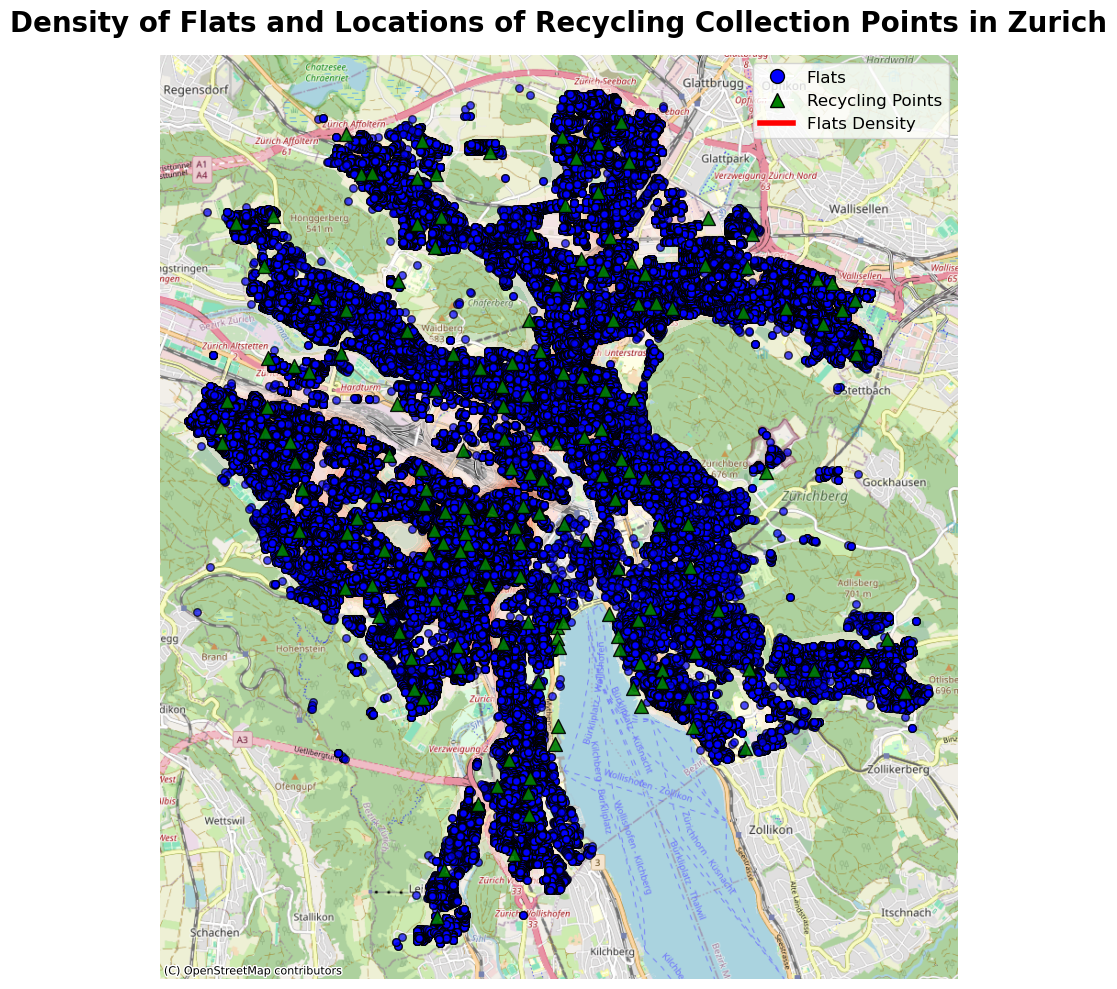

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import numpy as np
from shapely.geometry import Point
from matplotlib.lines import Line2D

# Define file paths
flats_path = './data/raw_data/geodata_stadt_Zuerich/building_stats/data/ssz.gwr_stzh_wohnungen.shp'
rcps_path = './data/raw_data/geodata_stadt_Zuerich/recycling_sammelstellen/data/stzh.poi_sammelstelle_view.shp'

# Load GeoDataFrames
flats_zh_existing = gpd.read_file(flats_path)
rcps = gpd.read_file(rcps_path)

# Convert to Web Mercator CRS (EPSG:3857)
flats_zh_existing = flats_zh_existing.to_crs(epsg=3857)
rcps = rcps.to_crs(epsg=3857)

# Extract coordinates for KDE
flats_coords = flats_zh_existing.geometry.apply(lambda geom: (geom.x, geom.y))
flats_x = [coord[0] for coord in flats_coords]
flats_y = [coord[1] for coord in flats_coords]

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot KDE heatmap for Flats
sns.kdeplot(
    x=flats_x,
    y=flats_y,
    cmap="Reds",
    shade=True,
    shade_lowest=False,
    alpha=0.5,
    bw_adjust=0.5,
    ax=ax,
    label='Flats Density'
)

# Plot Flats
flats_zh_existing.plot(
    ax=ax,
    color='blue',
    markersize=30,
    alpha=0.7,
    label='Flats',
    edgecolor='k'
)

# Plot Recycling Points
rcps.plot(
    ax=ax,
    color='green',
    markersize=100,
    marker='^',
    alpha=0.9,
    label='Recycling Points',
    edgecolor='k'
)

# Add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add Title
plt.title('Density of Flats and Locations of Recycling Collection Points in Zurich', fontsize=20, fontweight='bold')

# Define custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Flats',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='^', color='w', label='Recycling Points',
           markerfacecolor='green', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], color='red', lw=4, label='Flats Density')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Remove Axes
ax.set_axis_off()

# Save the map as a PNG image with high resolution
fig.savefig('./data/derived_data/map_flats_rcps_heatmap.png', dpi=300, bbox_inches='tight')

# Display the map
plt.show()